<a href="https://colab.research.google.com/github/StephenSpicer/Unit_02_Clone/blob/master/Stephen_Lupsha_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv',
                parse_dates=['Date'],
                index_col='Date')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [6]:
# okay now for some light EDA
df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,California,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,California,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Carnitas,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Asada,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-27,California,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2016-01-18 to 2019-08-27
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Yelp            87 non-null     float64
 2   Google          87 non-null     float64
 3   Chips           26 non-null     object 
 4   Cost            414 non-null    float64
 5   Hunger          418 non-null    float64
 6   Mass (g)        22 non-null     float64
 7   Density (g/mL)  22 non-null     float64
 8   Length          283 non-null    float64
 9   Circum          281 non-null    float64
 10  Volume          281 non-null    float64
 11  Tortilla        421 non-null    float64
 12  Temp            401 non-null    float64
 13  Meat            407 non-null    float64
 14  Fillings        418 non-null    float64
 15  Meat:filling    412 non-null    float64
 16  Uniformity      419 non-null    float64
 17  Salsa           

In [8]:
df.fillna(value=0, axis=1, inplace=True)

In [11]:
df.head()

,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-18,California,3.5,4.2,0,6.49,3.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,x,x,x,x,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False
2016-01-24,California,3.5,3.3,0,5.45,3.5,0.0,0.0,0.0,0.0,0.0,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,x,x,x,x,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False
2016-01-24,Carnitas,0.0,0.0,0,4.85,1.5,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,x,x,0,0,0,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False
2016-01-24,Asada,0.0,0.0,0,5.25,2.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,x,x,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False
2016-01-27,California,4.0,3.8,x,6.59,4.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,x,x,0,x,x,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,True


 Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [14]:
# First, X and y

target = 'Great'
y = df[target]
X = df.drop(columns = target)

# Now we use the train test split function. 

In [31]:
# Sounds like I need some cutoffs going on here... except we want to split first
# between training and test, then get validation out from the training set. 

cutoff_train = '2017-01-01'
mask_train = X.index < cutoff_train

X_train, y_train = X.loc[mask_train], y.loc[mask_train]

cutoff_test = '2017-12-31'
mask_test = X.index > cutoff_test
X_test, y_test = X.loc[mask_test], y.loc[mask_test]

cutoff_validation = 2017
mask_val = X.index.year == cutoff_validation

X_val, y_val = X.loc[mask_val], y.loc[mask_val]

# Now I'll have a look at these shapes... 
print('X_Train Shape:', X_train.shape,'y_train Shape:', y_train.shape, 'X_val Shape:', X_val.shape, 'y_val Shape:', y_val.shape, 'X_test Shape:', X_test.shape, 'y_test Shape:', y_test.shape)

X_Train Shape: (298, 57) y_train Shape: (298,) X_val Shape: (85, 57) y_val Shape: (85,) X_test Shape: (38, 57) y_test Shape: (38,)


In [12]:
# Our friend Nicholas calls this sort of cell a preamble, but I think mine is too far down the notebook for that title to still work. 
# LETS IMPORT SOME THINGS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Baseline :


In [32]:
print('Baseline Accuracy Score for a burrito being Great', y_train.value_counts(normalize=True).max())

Baseline Accuracy Score for a burrito being Great 0.5906040268456376


In [33]:
df['Great'].value_counts()

False    239
True     182
Name: Great, dtype: int64

In [46]:


model_reg = make_pipeline(
    OneHotEncoder(use_cat_names=True, handle_unknown='ignore'),
    SimpleImputer(strategy='mean'),
    LogisticRegression()
)

model_reg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Burrito', 'Chips', 'Unreliable', 'NonSD',
                                     'Beef', 'Pico', 'Guac', 'Cheese', 'Fries',
                                     'Sour cream', 'Pork', 'Chicken', 'Shrimp',
                                     'Fish', 'Rice', 'Beans', 'Lettuce',
                                     'Tomato', 'Bell peper', 'Carrots',
                                     'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro',
                                     'Onion', 'Taquito', 'Pineapple', 'Ham',
                                     'Chile relleno', 'Nopales', ...],
                               dr...
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, d

In [47]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9093959731543624
Validation Accuracy: 0.8117647058823529


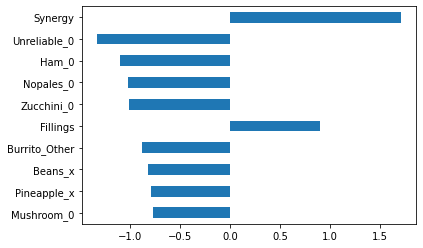

In [56]:
features = model_reg.named_steps['onehotencoder'].get_feature_names()
coefficients = model_reg.named_steps['logisticregression'].coef_[0]
feat_importances = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_importances.tail(10).plot(kind='barh')

In [55]:
print(coefficients.shape)

(1, 123)


In [50]:
print(features)

['Burrito_California', 'Burrito_Carnitas', 'Burrito_Asada', 'Burrito_Other', 'Burrito_Surf & Turf', 'Yelp', 'Google', 'Chips_0', 'Chips_x', 'Chips_X', 'Cost', 'Hunger', 'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Unreliable_0', 'Unreliable_x', 'NonSD_0', 'NonSD_x', 'NonSD_X', 'Beef_x', 'Beef_0', 'Beef_X', 'Pico_x', 'Pico_0', 'Pico_X', 'Guac_x', 'Guac_0', 'Guac_X', 'Cheese_x', 'Cheese_0', 'Cheese_X', 'Fries_x', 'Fries_0', 'Fries_X', 'Sour cream_0', 'Sour cream_x', 'Sour cream_X', 'Pork_0', 'Pork_x', 'Pork_X', 'Chicken_0', 'Chicken_x', 'Chicken_X', 'Shrimp_0', 'Shrimp_x', 'Shrimp_X', 'Fish_0', 'Fish_x', 'Fish_X', 'Rice_0', 'Rice_x', 'Rice_X', 'Beans_0', 'Beans_x', 'Beans_X', 'Lettuce_0', 'Lettuce_x', 'Lettuce_X', 'Tomato_0', 'Tomato_x', 'Tomato_X', 'Bell peper_0', 'Bell peper_x', 'Bell peper_X', 'Carrots_0', 'Carrots_x', 'Cabbage_0', 'Cabbage_x', 'Cabbage_X', 'Sauce_0', 'Sau

In [58]:
# Let's check some metrics here. 
print('Accuracies :')
print('Training:', model_reg.score(X_train, y_train))
print('Validation:', model_reg.score(X_val, y_val))
print('Test:', model_reg.score(X_test, y_test))

Accuracies :
Training: 0.9093959731543624
Validation: 0.8117647058823529
Test: 0.6842105263157895


In [ ]:
# I've got to get some tuning done. Going to submit for now and resubmit again after some sprint studying. 